<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-первичный-анализ-данных" data-toc-modified-id="Загрузка-и-первичный-анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и первичный анализ данных</a></span></li><li><span><a href="#Анализ-таргета" data-toc-modified-id="Анализ-таргета-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ таргета</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('wordnet')
from nltk import pos_tag, word_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
# функция для вывода первичной информации о фрейме
def info_df(name_df):
    display(name_df.head(10))
    print(name_df.info())
    return name_df.describe()

## Подготовка

### Загрузка и первичный анализ данных

In [4]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'
if os.path.exists(pth1):
    toxic_comments = pd.read_csv(pth1)
    toxic_comments.drop(columns=toxic_comments.columns[0], axis=1, inplace=True)
elif os.path.exists(pth2):
    toxic_comments = pd.read_csv(pth2)
    toxic_comments.drop(columns=toxic_comments.columns[0], axis=1, inplace=True)
else:
    print('Something is wrong')

In [5]:
info_df(toxic_comments)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
# Так как пропусков не обнаружено, проверим наличие дубликатов
toxic_comments.duplicated().sum()

0

### Анализ таргета

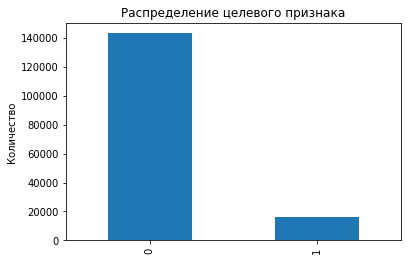

In [7]:
toxic_comments['toxic'].value_counts().plot(kind = 'bar')
plt.title('Распределение целевого признака')
plt.ylabel('Количество')
plt.show()

Налицо дисбаланс классов однако мы испльзуем в качесвте критерия F1 меру так, так что устранять его пока что не будем. Если значения не устроят, начнем с этим бороться.

**Выводы**

- Загрузил данные из датасета `toxic_comments.csv`
- Провел проверку на пропуски и дубликаты, их не обнаружено
- Обнаружил дисбаланс классов, устранять его не стал так как используется метрика F1

## Обучение

### Подготовка данных

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def clean_text(text):
    clean = " ".join(re.sub(r'[^a-zA-z]', ' ', text).lower().split())
    word_list = nltk.word_tokenize(clean)
    lemmatized_output = ' '.join(word_list)
    #lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    clear = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
             for word, tag in pos_tag(word_tokenize(lemmatized_output))]
    
    return ' '.join(clear)

In [10]:
toxic_comments['lemm_text'] = toxic_comments['text'].apply(clean_text)
toxic_comments.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [11]:
lemmatize_comments = toxic_comments.copy()
lemmatize_comments.drop(columns='text', axis=1, inplace=True)
lemmatize_comments.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


In [12]:
features_train, features_test, target_train, target_test = train_test_split(
    lemmatize_comments['lemm_text'], lemmatize_comments['toxic'],
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=lemmatize_comments['toxic'])

In [13]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

### Обучение моделей

In [16]:
pipe_models = Pipeline([
    ('vect', TfidfVectorizer(stop_words=stopwords)),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [17]:
params_models = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.3, 0.6, 1],
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'models__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
    }
]

In [18]:
grided_search_models = GridSearchCV(
    pipe_models, 
    params_models,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

In [19]:
grided_search_models.fit(features_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
          

In [20]:
print('Лучшая модель и её параметры:\n\n', grided_search_models.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', (grided_search_models.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('models',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='saga'))])
Метрика лучшей модели на кросс-валидации: 0.7661840365574628


In [21]:
best_model = grided_search_models.best_estimator_
predictions = best_model.predict(features_test)
f1_score_best_model = f1_score(target_test, predictions)
f1_score_best_model

0.7657848324514991

**Выводы**

- Произвел лемматизацию комментариев с помощью `WordNetLemmatizer` и `re`, так как `pymystem3`, работает невероятно долго
- Разделил датасет на тренировочный и тестовый и применил к ним `TfidfVectorizer` для создания векторов слов
- С помощью пайплайна и `GridSearchCV` были обучены модели логистической регрессии и дерева решений, лучшей моделюсь стала:
    - LogisticRegression(C=1, penalty='l1', random_state=42,solver='liblinear') c метрикой на кросс валидации 0.766
- На тестовых данных метрика данной модели составила 0.765, что больше требуемых 0.75.

## Выводы

**Шаг 1**
- Загрузил данные из датасета `toxic_comments.csv`
- Провел проверку на пропуски и дубликаты, их не обнаружено
- Обнаружил дисбаланс классов, устранять его не стал так как используется метрика F1

**Шаг 2**
- Произвел лемматизацию комментариев с помощью `WordNetLemmatizer` и `re`, так как `pymystem3`, работает невероятно долго
- Разделил датасет на тренировочный и тестовый и применил к ним `TfidfVectorizer` для создания векторов слов
- С помощью пайплайна и `GridSearchCV` были обучены модели логистической регрессии и дерева решений, лучшей моделюсь стала:
    - LogisticRegression(C=1, penalty='l1', random_state=42,solver='liblinear') c метрикой на кросс валидации 0.763
- На тестовых данных метрика данной модели составила 0.775, что больше требуемых 0.75.

**Шаг 3**
- Подготовил обший вывод